# Cyber Data Analytics, CS4035
## Lab assignment 1: Fraud detection
### April 2019

**Group 20**:
- Konstantinos Chronas, 4923162
- Ioannis Lelekas, 4742559

## Data importing and preprocessing:
- importing data from csv to dataframe
- drop records corresponding to "Refused" transactions
- drop records correspodning NaNs
- conversion of categorical data to numeric

In [73]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('./data_for_student_case.csv', sep = ',')

# Drop records corresponding to "Refused" transactions
data = data[data['simple_journal'] != 'Refused']

# Assess amount of NaN values
orig_shape = data.shape
nas = data.isna()
nas_id = np.sum(nas, 1)

print("Amount of nan values in Chargeback: ", np.sum(data['simple_journal'][nas_id > 0] == 'Chargeback'), "\n")
print("NaN values per feature:\n", np.sum(nas, 0), "\n")

# Drop records containing NaNs
data = data.dropna()
print("Number of NaN values omitted: ", orig_shape[0] - data.shape[0], "\n")

# Uncomment this line to see the type of features
# print(data.dtypes)

# Print counts of records corresponding to "Chargeback" (fraud), "Settled" (non-fraud) transactions,
# along with the repsective ratios. This is a perfect demonstration of the imbalance of the dataset.
labels = data['simple_journal']
print("Number of non-fraud: ", np.sum(labels == 'Settled'), ", with ratio: ", np.sum(labels == 'Settled')/len(labels))
print("Number of fraud: ", np.sum(labels == 'Chargeback'), ", with ratio: ", np.sum(labels == 'Chargeback')/len(labels))

data.groupby(by = 'simple_journal').count()

Amount of nan values in Chargeback:  0 

NaN values per feature:
 txid                                0
bookingdate                         0
issuercountrycode                   4
txvariantcode                       0
bin                                 0
amount                              0
currencycode                        0
shoppercountrycode                342
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    13194
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64 

Number of NaN values omitted:  13526 

Number of non-fraud:  223165 , with ratio:  0.9984564449017941
Number of fraud:  345 , with ratio:  0.0015435550982058968


,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
simple_journal,,,,,,,,,,,,,,,,
Chargeback,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345
Settled,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165


### Convesion of categorical data to numeric
Each column of type "object" is converted, based on an enumeration of its unique values. We did not use one-hot encoding for the conversion, as this would lead to unnecessary creation of extra columns, thus to the increase of the dimensionality of feature space.

We define a mapping for the 'currencycode' in order to produce a transformed amount by multiplying the original amount with this mapping. We substitute then the 'amount' column with this transformed amount.

Finally, we keep data and data_cat, which are the transformed numeric data and the original categorical data respectively (will be used in visualizations).

In [74]:
data_cat = data.copy(True)

# Storing the mapping used for the conversion, in case we want to revert back 
label_mapping = {}

# Convert currency code in order to 'amount' in a single code
label_mapping['numcurrencycode'] = {'SEK': 0.09703, 'MXN': 0.04358, 'AUD': 0.63161, 'NZD': 0.58377, 'GBP':1.13355} 
data['numcurrencycode'] = data['currencycode']
data.replace({'numcurrencycode' : label_mapping['numcurrencycode']}, inplace=True)
data['amount'] = data['amount'] * data['numcurrencycode']
data_cat['amount'] = data['amount']

label_mapping['simple_journal'] = {'Settled': 0, 'Chargeback' : 1}
data.replace({'simple_journal' : label_mapping['simple_journal']}, inplace=True)

# Convert all the rest columns which are of type 'object'
char_cols = data.dtypes.pipe(lambda x: x[x == 'object']).index

for c in char_cols:
    data[c], label_mapping[c] = pd.factorize(data[c])

# Uncomment this line, if you want to see the mapppings for the conversion
#label_mapping

## Visualization task

Simple demonstration of the imbalance present in the dataset. The non-fraud class by far outnumber the fraud class, with fraud transactions corresponding roughly to 0.15% of the taotal records.

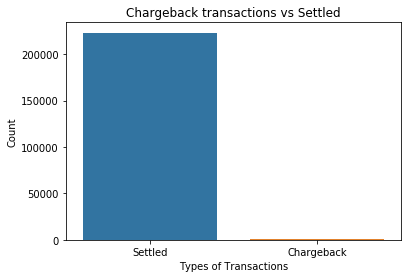

In [75]:
ax = data_cat['simple_journal'].value_counts()
plt.title('Chargeback transactions vs Settled')
sns.barplot(x=ax.index, y= ax)  
plt.xlabel('Types of Transactions')
plt.ylabel('Count')
plt.show()

Boxplot for the transormed amount regarding fraud and non-fraud transactions. Non-fraud transactions appear to have more symmetric distributions, with lower median value, but many outliers detected on the positive side. Regarding fraud transactions there is a higher median, with an obvious positive skew.

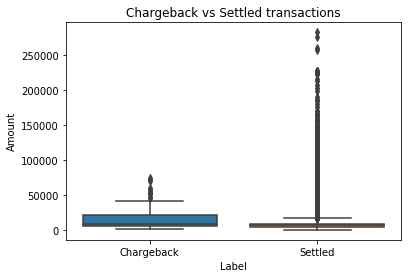

In [80]:
plt.title('Chargeback vs Settled transactions')
sns.boxplot(x="simple_journal", y="amount", data=data_cat)  
plt.xlabel('Label')
plt.ylabel('Amount')
plt.show()

The following visualization provides a histogram along with a kernel density estimate for the distribution of 
non-fraud(simple_journal=0) and fraud (simple_journal=1) transactions over the amount (transformend amount, multiplied by the currency code). The distribution of the 
non-fraud transactions appear to be more symmetric, appearing as well a higher mode. On the contrary, the fraud 
transactions' distribution appears significant positive skew. Regarding the fraud transactions the amount appears
to be more distributed in the range [0, 50000], whereas the vast majority of fraud transactions lie below 25000.

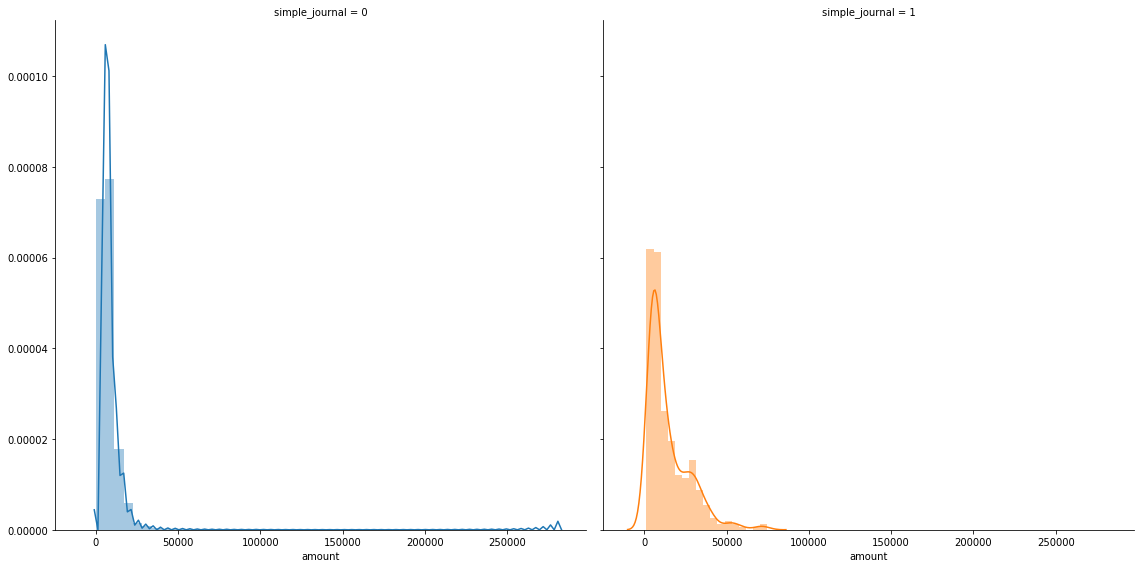

In [77]:
g = sns.FacetGrid(data, col="simple_journal", height=8,hue='simple_journal')
g.map(sns.distplot,"amount",kde=True)
# g.set_titles('Settled vs Chargeback')

Next, we provide barplot for the mean transformed amount versus the currency code, regarding fraud, non-fraud transactions and for the three shopperinteraction categories. Apparently, the vast majority of transactions in the dataset are "Ecommerce" with higher mean transformed amounts regarding fraud transactions. For shopperinteraction==ContAuth fraud transactions are only observed for currencycode==GBP, with the non-fraud transactions (roughly) evenly distributed among the other currency codes, with the exception of 'MXN', where no transactions at all are recorded. For POS transactions, no fraudulent ones occur, which was actually expected due to extra security codes required for this specific method; transactions only in 'GBP' occur here.

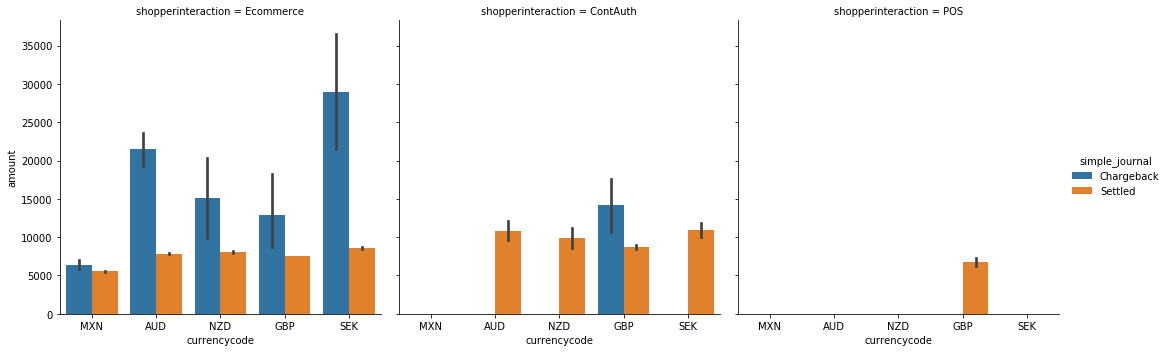

In [78]:
sns.catplot(data=data_cat,x="currencycode", y="amount", hue="simple_journal",kind='bar',col='shopperinteraction')

From the following boxplot we observe that fraud transactions are mainly
found where shopperinteraction==Ecommerce.

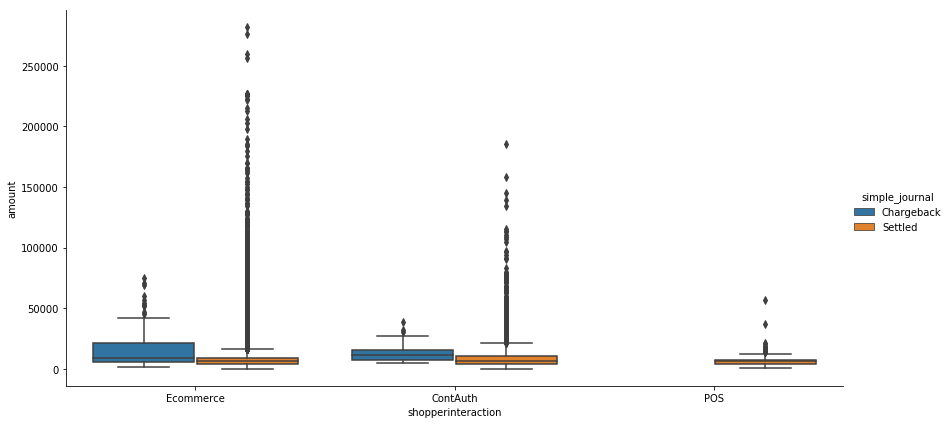

In [81]:
sns.catplot(data= data_cat,x="shopperinteraction", y="amount", hue="simple_journal",kind='box',height=6, aspect=2)

Barplot demonstrating the mean transformed amount per account code for non-fraud and fraud transactions. The mean amounts are more or less equal for the various account codes regarding settled transactions. Much higher mean values are observed for fraud transactions, with 'APACAccount' and 'SwedenAccount' being the two "naughtiest" account codes having the highest mean amounts. 

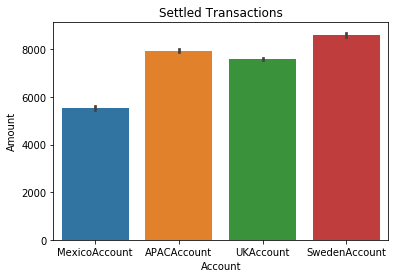

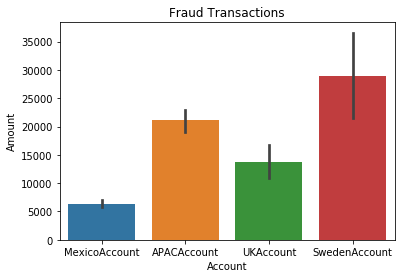

In [83]:
settled =data_cat.loc[data_cat['simple_journal']!='Chargeback']
plt.title('Settled Transactions')
sns.barplot(x="accountcode", y="amount", data=settled)  
plt.xlabel('Account')
plt.ylabel('Amount')
plt.show()

settled =data_cat.loc[data_cat['simple_journal']=='Chargeback']
plt.title('Fraud Transactions')
sns.barplot(x="accountcode", y="amount", data=settled)  
plt.xlabel('Account')
plt.ylabel('Amount')
plt.show()

Finally, we do provide some plots for the transformed amount aggregegated by 'card_id'. We do provide the count (number of transactions) and the mean value for settled and fraud transactions. At most 5 fraud transactions are conducted from a single account, with max mean transformed amount roughly equal to 800000.

Text(0, 0.5, 'Mean amount')

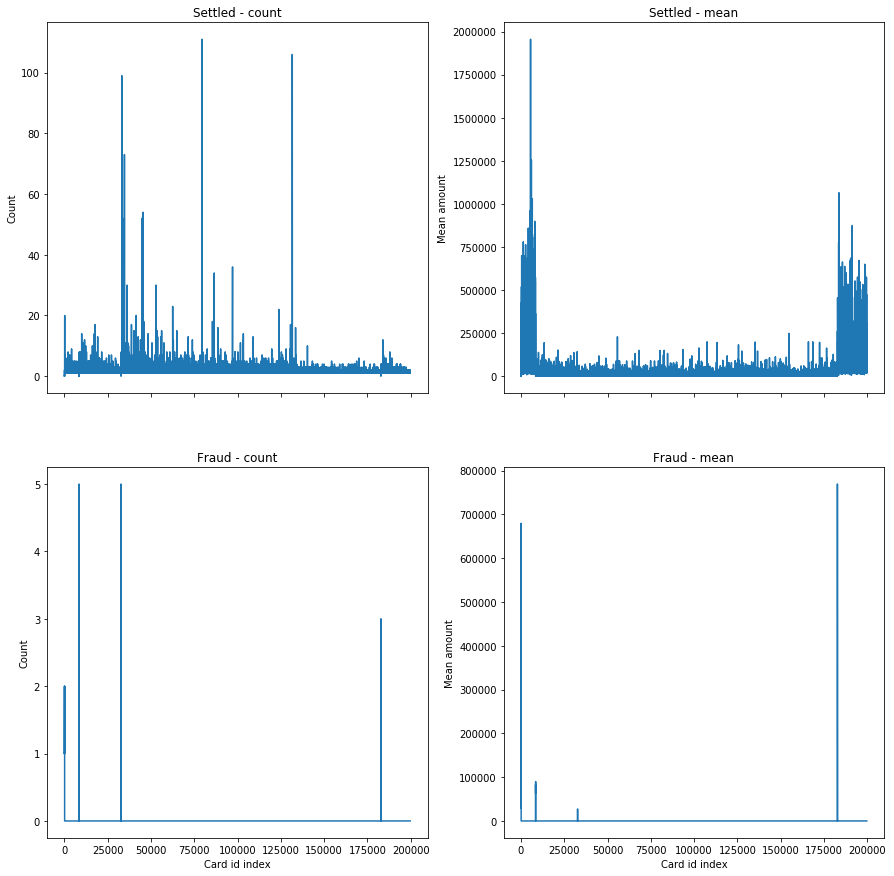

In [111]:
data_agg = data_cat[['card_id', 'simple_journal', 'amount']]

dd = pd.get_dummies(data_agg, columns = ['simple_journal'])

dd['sum_fraud'] = dd['amount'] * dd['simple_journal_Chargeback']
dd['sum_OK'] = dd['amount'] * dd['simple_journal_Settled']

dd_user = dd.groupby(by = 'card_id', sort = False).agg({
    'simple_journal_Settled' : sum,
    'sum_OK' : 'mean',
    'simple_journal_Chargeback' : sum,
    'sum_fraud' : 'mean'
})

f, ax = plt.subplots(2, 2, figsize = (15,15), sharex = True)

ax[0,0].plot(dd_user.values[:, 0])
ax[0,0].set_title("Settled - count")
ax[0,0].set_ylabel("Count")
ax[0,1].plot(dd_user.values[:, 1])
ax[0,1].set_title("Settled - mean")
ax[0,1].set_ylabel("Mean amount")
ax[1,0].plot(dd_user.values[:, 2])
ax[1,0].set_title("Fraud - count")
ax[1,0].set_xlabel("Card id index")
ax[1,0].set_ylabel("Count")
ax[1,1].plot(dd_user.values[:, 3])
ax[1,1].set_title("Fraud - mean")
ax[1,1].set_xlabel("Card id index")
ax[1,1].set_ylabel("Mean amount")

## Classification
### Imbalance task:
ROC analysis for various classifiers, with oue without use of SMOTE for dealing with the imabalance. We did test on more than the three required classifiers. The considered classifiers are:
- Naive Bayes,
- Linear Discriminant Analysis,
- Logistic Regression,
- Quadratic Discriminant Analysis
- Random Forest,
- Adaboost


### Classification task:
For the classification task, we we will further consider the classifiers
- Logistic Regression (LR) [White Box]
- Random Forest [Black Box]

In [4]:
from PlotConfusionMatrix import *
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from HelperFunctions import *
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.preprocessing import StandardScaler as StandardScaler

# Construct dataset and corresponding labels
X = data.drop(['simple_journal', 'creationdate', 'bookingdate', 'currencycode', 'numcurrencycode'], axis = 1).values
y = data['simple_journal'].values
print("Dataset shape: ", X.shape)


# # Imputing missing values.. we did eventually adopted the easier way of just dropping records corresponding to
# NaNs, as it led to nearly identical performance
# imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# print(np.sum(np.isnan(X)))
# X = imp.fit_transform(X)

# imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
# X = imp.fit_transform(X)

# Outut the number of samples corresponding to each class
# Non-Fraud: 0 (Negative label)
# Fraud: 1 (Postive label)
print("Fraud class samples: ", np.sum(y == 1))
print("Non-fraud class samples: ", np.sum(y == 0))
print("Ratio: ", np.sum(y == 1)/np.sum(y == 0))

# 10-Fold stratified cross validation with shuffling of the dataset before extracting the stratified splits,
# used for estimating performance
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

Dataset shape:  (223510, 13)
Fraud class samples:  345
Non-fraud class samples:  223165
Ratio:  0.0015459413438487217


#### Naive Bayes on UNSMOTEd data


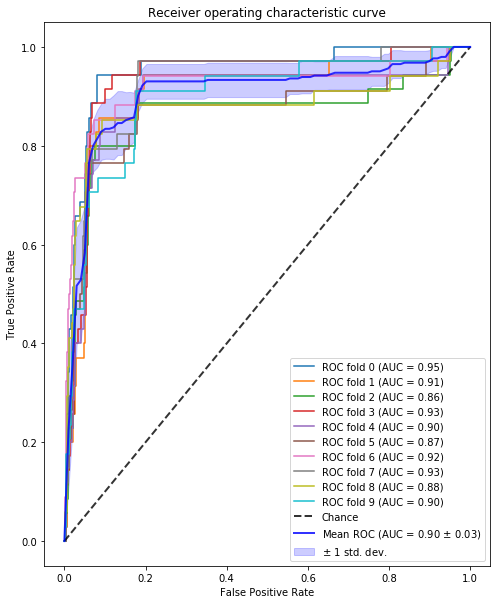

Confusion matrix, without normalization
[[211597  11568]
 [   127    218]]


<Figure size 432x288 with 0 Axes>

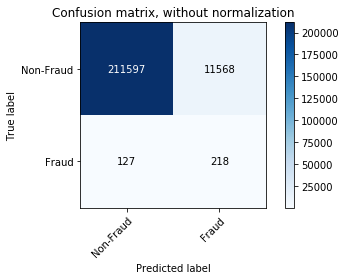

In [5]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

#### SMOTE
- first determine the best over-sampling ratio and the number of nearest neighbours used for the extraction of the random samples, which leads to best performance in terms of mean F1-score
- evaluation is conducted in terms of 10-fold Stratified cross-validation

In [7]:
# Use cross-validation to determine the best overasmpling ratio
ratios = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([5, 10, 100])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, y, clf, cv, 
                                                                                False, False, False, False, sm)
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
# print("std AUC:\n", std_auc_cv)
print("Mean F1:\n", m_F1_cv)
# print("std F1:\n", std_F1_cv)

Mean AUC:
 [[0.90159664 0.90181818 0.89238605]
 [0.90147016 0.90161107 0.88804686]
 [0.90224684 0.90160343 0.88931839]
 [0.90273067 0.90285375 0.88873016]
 [0.90264069 0.90298871 0.88930651]
 [0.90251846 0.90284441 0.88879382]
 [0.90285714 0.90361939 0.88849588]]
Mean F1:
 [[0.03576769 0.03536423 0.02388923]
 [0.01848866 0.01834648 0.01537228]
 [0.01578321 0.0158795  0.01495197]
 [0.01493886 0.01494731 0.01488749]
 [0.01506262 0.01495307 0.01537163]
 [0.01516428 0.01517217 0.0155326 ]
 [0.0153382  0.01533682 0.0154595 ]]


#### Naive Bayes for SMOTEd data
Perform SMOTE with the ratio and number of neighbours yielding the highest mean F1-score

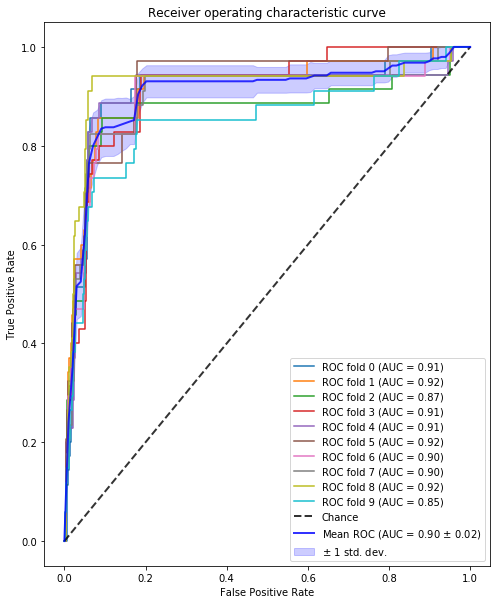

Confusion matrix, without normalization
[[208603  14562]
 [    74    271]]


<Figure size 432x288 with 0 Axes>

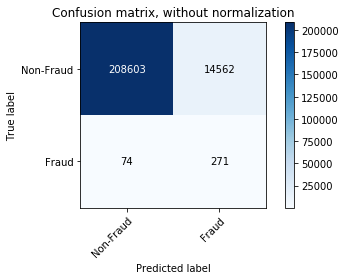

In [8]:
sm = SMOTE(sampling_strategy=0.01, k_neighbors=5)
nb_mean_tpr_sm, nb_std_tpr_sm, nb_mean_auc_sm, nb_std_auc_sm, mean_F1_sm, std_F1_sm, cm_sm = roc_analysis(X, y, clf, cv, True, True, True, False, sm)

#### Combined plot with ROC curves corresponding to SMOTEd and UNSMOTEd case

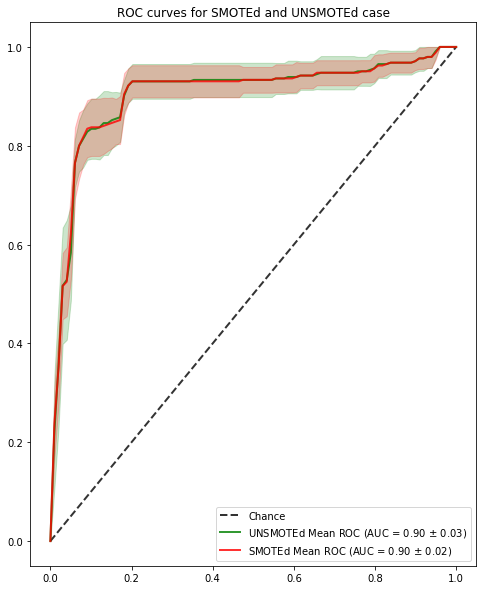

In [13]:
plt.figure(figsize = (8, 10))
plt.title("ROC curves for SMOTEd and UNSMOTEd case")
mean_fpr = np.linspace(0,1,100)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Chance', alpha=.8)

plt.plot(mean_fpr, nb_mean_tpr, color='g',
     label=r'UNSMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (nb_mean_auc, nb_std_auc),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(nb_mean_tpr - nb_std_tpr, 0), np.minimum(nb_mean_tpr + nb_std_tpr, 1),
                 color ='g', alpha=.2)

plt.plot(mean_fpr, nb_mean_tpr_sm, color='r',
     label=r'SMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (nb_mean_auc_sm, nb_std_auc_sm),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(nb_mean_tpr_sm - nb_std_tpr_sm, 0), 
                 np.minimum(nb_mean_tpr_sm + nb_std_tpr_sm, 1), color ='r', alpha=.2)

plt.legend()

#### Linear Discriminant Analysis on UNSMOTEd data

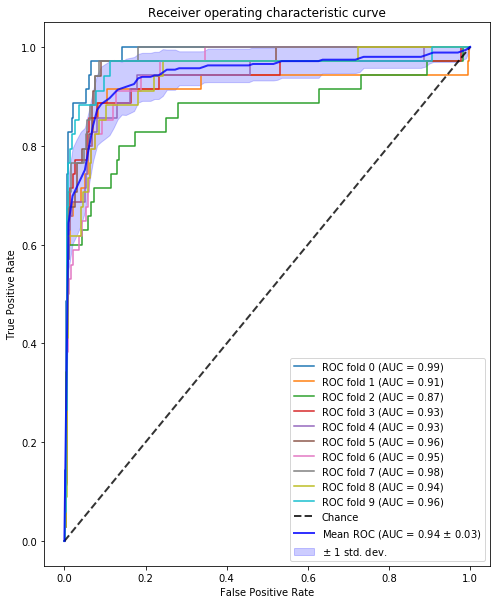

Confusion matrix, without normalization
[[222668    497]
 [   329     16]]


<Figure size 432x288 with 0 Axes>

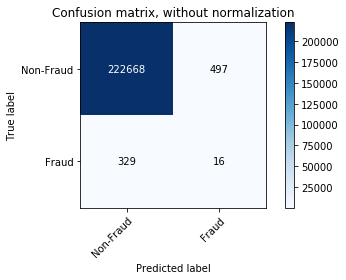

In [49]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA(solver='svd')
lda_mean_tpr, lda_std_tpr, lda_mean_auc, lda_std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

#### SMOTE
- first determine the best over-sampling ratio and the number of nearest neighbours used for the extraction of the random samples, which leads to best performance in terms of mean F1-score
- evaluation is conducted in terms of 10-fold Stratified cross-validation

In [53]:
# Use cross-validation to determine the best overasmpling ratio
# ratios = np.arange(0.1, 1, 0.1)
ratios = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([5, 10, 100])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, y, clf, cv, 
                                                                                False, False, False, False, sm)
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
print("Mean F1:\n", m_F1_cv)

Mean AUC:
 [[0.94289194 0.94255836 0.93721755]
 [0.94517189 0.94502504 0.93910534]
 [0.94836007 0.94804261 0.9426738 ]
 [0.95195739 0.95115865 0.94417452]
 [0.95648926 0.95552585 0.95084034]
 [0.9595688  0.95905186 0.95381207]
 [0.96032086 0.9593532  0.95536372]]
Mean F1:
 [[0.10201923 0.09511068 0.13228816]
 [0.13808555 0.13864228 0.10258485]
 [0.08386998 0.08425707 0.05969298]
 [0.04855507 0.04930173 0.04117844]
 [0.02098686 0.02201887 0.02165349]
 [0.01639801 0.01693473 0.01733822]
 [0.01562268 0.01585995 0.01635465]]


#### Linear Discriminant Analysis on SMOTEd data
Perform SMOTE with the ratio and number of neighbours yielding the highest mean F1-score

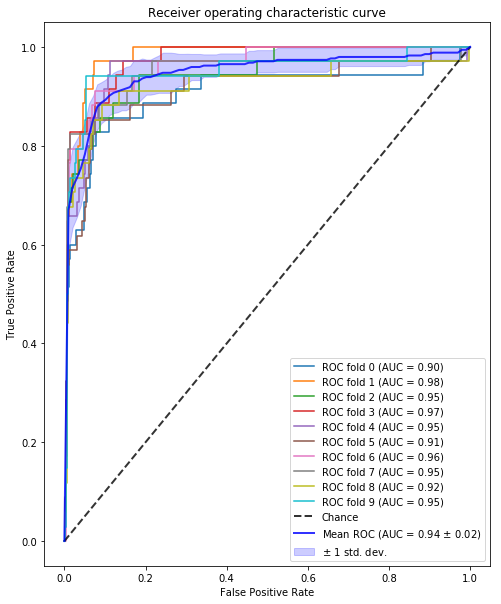

Confusion matrix, without normalization
[[220390   2775]
 [   110    235]]


<Figure size 432x288 with 0 Axes>

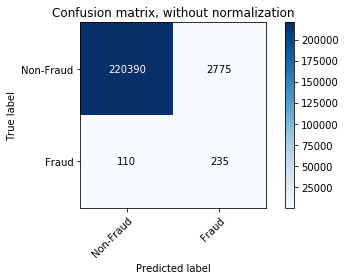

In [54]:
sm = SMOTE(sampling_strategy=0.05, k_neighbors=5)
lda_mean_tpr_sm, lda_std_tpr_sm, lda_mean_auc_sm, lda_std_auc_sm, mean_F1, std_F1, cm_sm = roc_analysis(X, y, clf, cv, True, True, True, False, sm)

#### Combined plot corresponding to SMOTEd and UNSMOTEd case

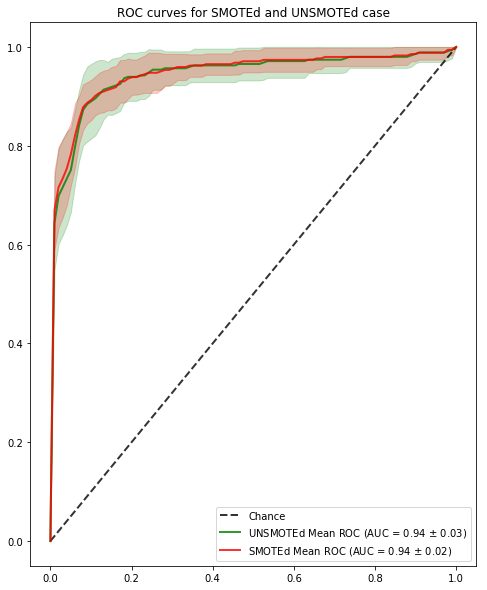

In [56]:
# Combined plot with ROC curves corresponding to the SMOTEd and UNSMOTEd case of the considered classifier
plt.figure(figsize = (8, 10))
plt.title("ROC curves for SMOTEd and UNSMOTEd case")
mean_fpr = np.linspace(0,1,100)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Chance', alpha=.8)

plt.plot(mean_fpr, lda_mean_tpr, color='g',
     label=r'UNSMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (lda_mean_auc, lda_std_auc),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(lda_mean_tpr - lda_std_tpr, 0), np.minimum(lda_mean_tpr + lda_std_tpr, 1), 
                 color ='g', alpha=.2)

plt.plot(mean_fpr, lda_mean_tpr_sm, color='r',
     label=r'SMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (lda_mean_auc_sm, lda_std_auc_sm),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(lda_mean_tpr_sm - lda_std_tpr_sm, 0), 
                 np.minimum(lda_mean_tpr_sm + lda_std_tpr_sm, 1), color ='r', alpha=.2)

plt.legend()

#### White Box: Logistic Regression on UNSMOTEd data
Logistic regression will serve as our white box classifier. First, check performance on UNSMOTEd data

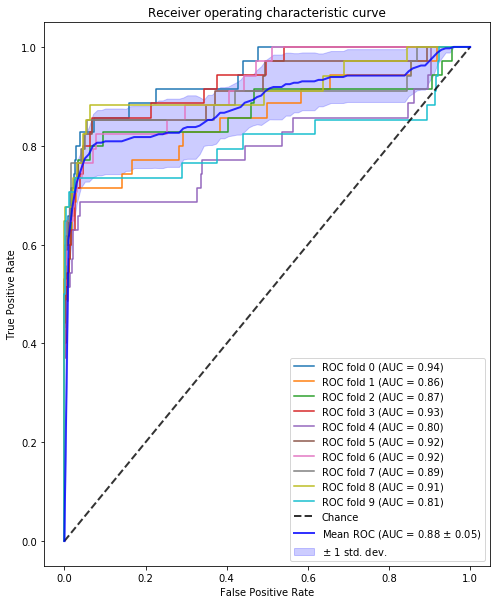

Confusion matrix, without normalization
[[223157      8]
 [   345      0]]


<Figure size 432x288 with 0 Axes>

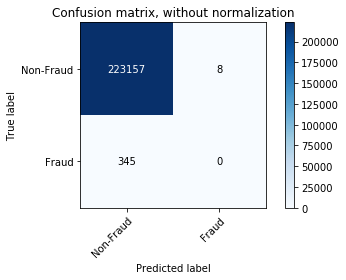

In [20]:
from  sklearn.linear_model import LogisticRegression as LR


clf = LR(C = 1, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)
lr_mean_tpr, lr_std_tpr, lr_mean_auc, lr_std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

#### SMOTE
- first determine the best over-sampling ratio and the number of nearest neighbours used for the extraction of the random samples, which leads to best performance in terms of mean F1-score
- evaluation is conducted in terms of 10-fold Stratified cross-validation

In [15]:
# Use cross-validation to determine the best overasmpling ratio and number of neighbours
# ratios = np.arange(0.1, 1, 0.1)
ratios = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([5, 10, 100])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, y, clf, cv, 
                                                                                False, False, False, False, sm)

        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
print("Mean F1:\n", m_F1_cv)

Mean AUC:
 [[0.89471946 0.89588235 0.89312198]
 [0.91617095 0.91629658 0.91032595]
 [0.92253204 0.92281385 0.91967066]
 [0.92654359 0.92490451 0.9264604 ]
 [0.92958832 0.92857822 0.92941261]
 [0.92987098 0.92994058 0.92866565]
 [0.92926067 0.92840506 0.93009677]]
Mean F1:
 [[0.02305916 0.02813813 0.2044468 ]
 [0.15737128 0.16523498 0.29883146]
 [0.18331915 0.17307891 0.19937308]
 [0.08127063 0.07959556 0.08076042]
 [0.02035375 0.02110387 0.02224823]
 [0.01613369 0.01645856 0.01730385]
 [0.0154178  0.01543298 0.0161642 ]]


#### Logistic Regression for SMOTEd data
Perform SMOTE with the ratio and number of neighbours yielding the highest mean F1-score

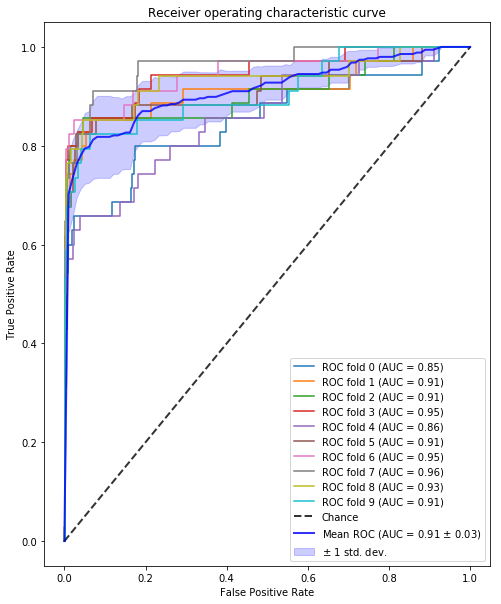

Confusion matrix, without normalization
[[222546    619]
 [   174    171]]


<Figure size 432x288 with 0 Axes>

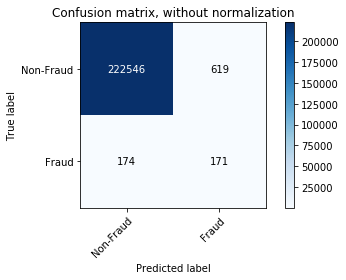

In [17]:
sm = SMOTE(sampling_strategy=0.05, k_neighbors=100)
lr_mean_tpr_sm, lr_std_tpr_sm, lr_mean_auc_sm, lr_std_auc_sm, mean_F1_sm, std_F1_sm, cm_sm = roc_analysis(X, y, clf, cv, True, True, True, False, sm)

#### Combined plot with ROC curves corresponding to SMOTEd and UNSMOTEd case

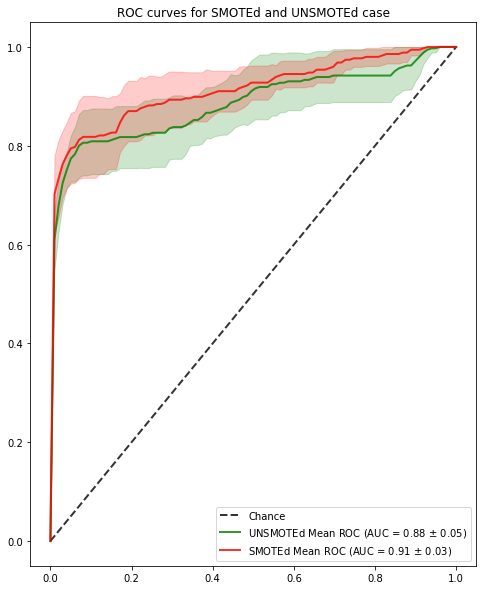

In [22]:
plt.figure(figsize = (8, 10))
plt.title("ROC curves for SMOTEd and UNSMOTEd case")
mean_fpr = np.linspace(0,1,100)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Chance', alpha=.8)

plt.plot(mean_fpr, lr_mean_tpr, color='g',
     label=r'UNSMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (lr_mean_auc, lr_std_auc),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(lr_mean_tpr - lr_std_tpr, 0), np.minimum(lr_mean_tpr + lr_std_tpr, 1), 
                 color ='g', alpha=.2)

plt.plot(mean_fpr, lr_mean_tpr_sm, color='r',
     label=r'SMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (lr_mean_auc_sm, lr_std_auc_sm),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(lr_mean_tpr_sm - lr_std_tpr_sm, 0), 
                 np.minimum(lr_mean_tpr_sm + lr_std_tpr_sm, 1), color ='r', alpha=.2)

plt.legend()

#### Combined plot with ROC curves for SMOTEd and UNSMOTEd case for the Naive Bayes, Logistic Regression and Linear Discriminant Analysis classifiers for Imbalance Task


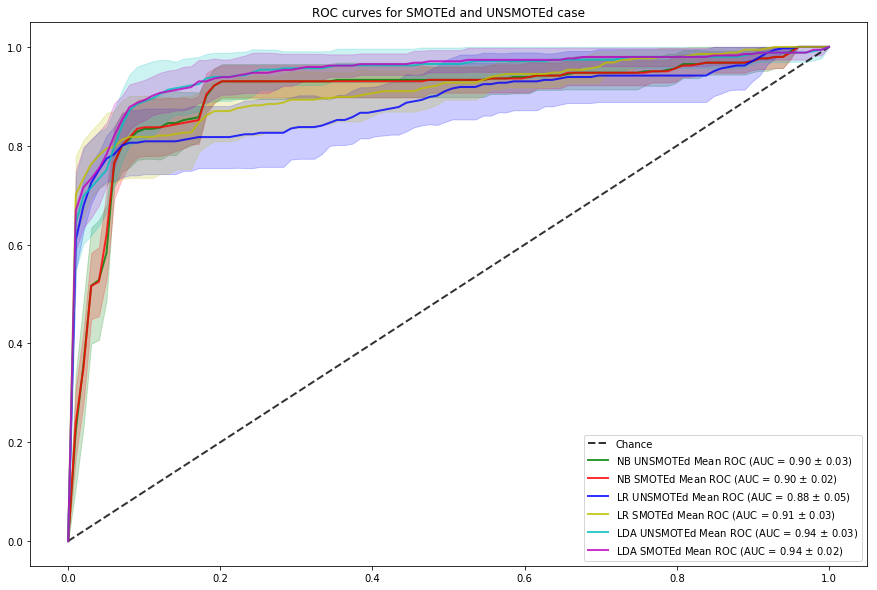

In [71]:
plt.figure(figsize = (15, 10))
plt.title("ROC curves for SMOTEd and UNSMOTEd case")
mean_fpr = np.linspace(0,1,100)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Chance', alpha=.8)

plt.plot(mean_fpr, nb_mean_tpr, color='g',
     label=r'NB UNSMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (nb_mean_auc, nb_std_auc),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(nb_mean_tpr - nb_std_tpr, 0), np.minimum(nb_mean_tpr + nb_std_tpr, 1),
                 color ='g', alpha=.2)

plt.plot(mean_fpr, nb_mean_tpr_sm, color='r',
     label=r'NB SMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (nb_mean_auc_sm, nb_std_auc_sm),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(nb_mean_tpr_sm - nb_std_tpr_sm, 0), 
                 np.minimum(nb_mean_tpr_sm + nb_std_tpr_sm, 1), color ='r', alpha=.2)

plt.plot(mean_fpr, lr_mean_tpr, color='b',
     label=r'LR UNSMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (lr_mean_auc, lr_std_auc),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(lr_mean_tpr - lr_std_tpr, 0), np.minimum(lr_mean_tpr + lr_std_tpr, 1), 
                 color ='b', alpha=.2)

plt.plot(mean_fpr, lr_mean_tpr_sm, color='y',
     label=r'LR SMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (lr_mean_auc_sm, lr_std_auc_sm),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(lr_mean_tpr_sm - lr_std_tpr_sm, 0), 
                 np.minimum(lr_mean_tpr_sm + lr_std_tpr_sm, 1), color ='y', alpha=.2)

plt.plot(mean_fpr, lda_mean_tpr, color='c',
     label=r'LDA UNSMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (lda_mean_auc, lda_std_auc),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(lda_mean_tpr - lda_std_tpr, 0), np.minimum(lda_mean_tpr + lda_std_tpr, 1), 
                 color ='c', alpha=.2)

plt.plot(mean_fpr, lda_mean_tpr_sm, color='m',
     label=r'LDA SMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (lda_mean_auc_sm, lda_std_auc_sm),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(lda_mean_tpr_sm - lda_std_tpr_sm, 0), 
                 np.minimum(lda_mean_tpr_sm + lda_std_tpr_sm, 1), color ='m', alpha=.2)


plt.legend()

#### Preprocessing for tuning the Logistic Regression classifier
- First scale the data, so all features have zero mean and unit variance,
- determine the best value for penalty parameter C based again on 10-fold cross-validation and the best F1-score

Here we tested both tuning the classifier  before applying SMOTE on scaled data, as well as tuning after applying SMOTE on the scaled data. The former case did not actually let us to perform any tuning since the classifier consistently detected approximately zero TP (hence 0 F1-score) so we did drop this case. Therefore, we do tune the classifier on SMOTEd and scaled dataset, which again though leads to pretty similar performance.

Additionally, we tested using other methods than 'lbgfs', but they led to extremely long running times and since we had already met the performance requirements we decided to settle on 'lbfgs'.

In [24]:
from sklearn.preprocessing import StandardScaler as StandardScaler

# Scale the data so they have 0 mean and unit variance
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [26]:
# Use cross-validation to determine the best overasmpling ratio and number of neighbours
# ratios = np.arange(0.1, 1, 0.1)
ratios = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([5, 10, 100])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X_scaled, y, clf, cv, 
                                                                                False, False, False, False, sm)

        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
print("Mean F1:\n", m_F1_cv)

Mean AUC:
 [[0.94741109 0.94721501 0.94471182]
 [0.95948816 0.95903149 0.95310245]
 [0.96263815 0.96302521 0.95840845]
 [0.96486037 0.96653849 0.96355573]
 [0.96730244 0.9672218  0.9650887 ]
 [0.96932009 0.96815466 0.96398184]
 [0.9703599  0.96890671 0.9655615 ]]
Mean F1:
 [[0.38975112 0.4386362  0.547625  ]
 [0.30611473 0.31622242 0.34298158]
 [0.26211015 0.26011257 0.26646331]
 [0.20289513 0.20135096 0.19307264]
 [0.10743489 0.11085187 0.10535114]
 [0.07168277 0.07608879 0.07430181]
 [0.0607072  0.06371556 0.06447573]]


#### Logistic regression classifier on SMOTEd, scaled data

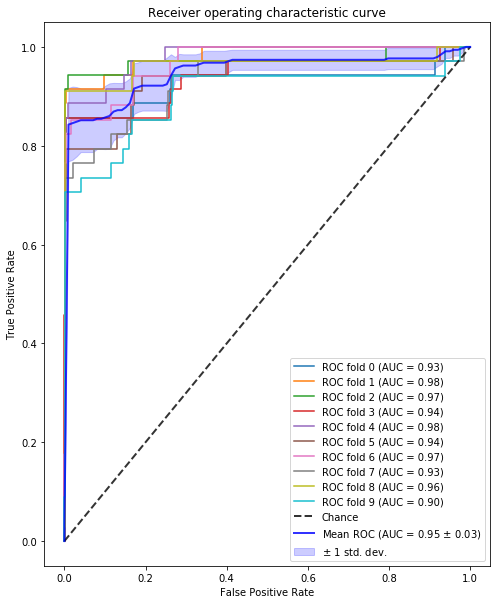

Confusion matrix, without normalization
[[223009    156]
 [   155    190]]


<Figure size 432x288 with 0 Axes>

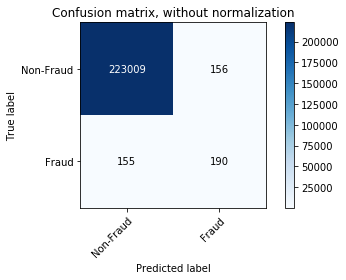

In [35]:
sm = SMOTE(sampling_strategy=0.01, k_neighbors=100)
lrt_mean_tpr_sm, lrt_std_tpr_sm, lrt_mean_auc_sm, lrt_std_auc_sm, mean_F1_sm, std_F1, cm_sm = roc_analysis(X_scaled, y, clf, cv, True, True, True, False, sm)

In [36]:
# Use cross-validation to determine the best value for C parameter and the optimal solver used for LR classifier
# ratios = np.arange(0.1, 1, 0.1)
C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
# solver = np.array(['newton-cg', 'lbfgs', 'sag', 'saga'])
solver = np.array(['lbfgs'])

sm = SMOTE(sampling_strategy=0.01, k_neighbors=100)

# Arrays for keeping mean values and standard deviations extracted by 10-fold crossval for each set of parameters
m_auc_cv = np.zeros((len(C), len(solver)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for c in C: 
    j = 0
    for s in solver:
        clf = LR(C = c, solver = s, multi_class='ovr', n_jobs=-1)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X_scaled, y, clf, cv, 
                                                                                False, False, False, False, sm)
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to C values and columns to solvers
print("Mean AUC:\n", m_auc_cv)
print("Mean F1:\n", m_F1_cv)

Mean AUC:
 [[0.89833461]
 [0.92080129]
 [0.9478304 ]
 [0.94512945]
 [0.94421187]
 [0.93708768]
 [0.94190137]]
Mean F1:
 [[0.        ]
 [0.        ]
 [0.06598358]
 [0.54286029]
 [0.57033724]
 [0.57779919]
 [0.57797668]]


#### Tuned Logistic Regression classifier on SMOTEd, scaled data

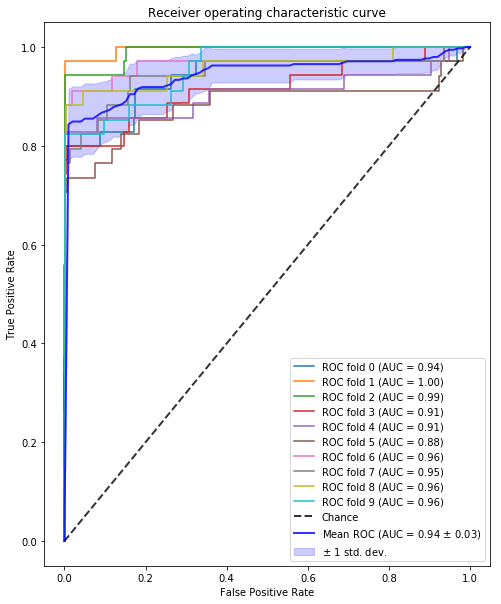

Confusion matrix, without normalization
[[222996    169]
 [   137    208]]


<Figure size 432x288 with 0 Axes>

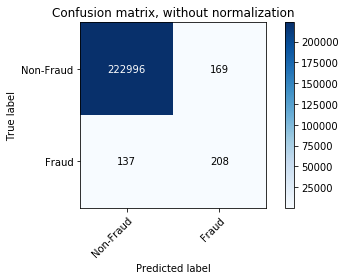

In [38]:
clf = LR(C = 1000, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)
sm = SMOTE(sampling_strategy=0.01, k_neighbors=100)
lrt_mean_tpr, lrt_std_tpr, lrt_mean_auc, lrt_std_auc, lrt_mean_F1, lrt_std_F1, cm = roc_analysis(X_scaled, y, clf, cv, True, True, True, False, sm)

#### Black box: Random Forest on UNSMOTEd data
This is our black box classifier. Apparently, it meets the requirements right away reaching almost flawless performance on the dataset. Hence, we did not proceed on applying SMOTE for this classifier. We did though proceed to some tuning, in essence testing performance for various number of estimators used by the ensemble classifier. As shown below, even 10 estimators suffice for nearly perfect performance!



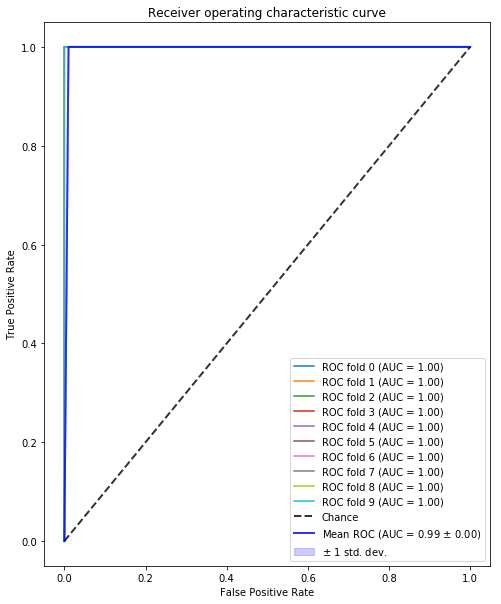

Confusion matrix, without normalization
[[223163      2]
 [     4    341]]


<Figure size 432x288 with 0 Axes>

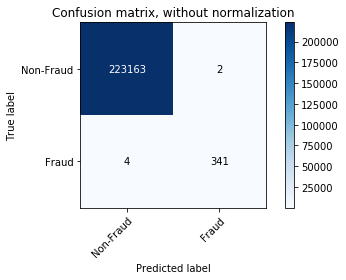

In [43]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
rf_mean_tpr, rf_std_tpr, rf_mean_auc, rf_std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

#### Classifier tuning:
Determine the optimal
- number of estimators and 
- criterion used for splitting

In [45]:
# Use cross-validation to determine the best overasmpling ratio
# ratios = np.arange(0.1, 1, 0.1)
n_estimators = np.array([10, 100, 1000])
criterion = solver = np.array(['gini', 'entropy'])

m_auc_cv = np.zeros((len(C), len(solver)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for n in n_estimators: 
    j = 0
    for c in criterion:
        clf = RF(n_estimators=n, criterion=c, n_jobs=-1)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, y, clf, cv, 
                                                                                False, False, False, False, sm)
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to C values and columns to solvers
print("Mean AUC:\n", m_auc_cv)
print("Mean F1:\n", m_F1_cv)

Mean AUC:
 [[0.99494949 0.99494949]
 [0.99494949 0.99494949]
 [0.99494949 0.99494949]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
Mean F1:
 [[0.99552239 0.99424431]
 [0.99705819 0.99850746]
 [0.99850746 0.99710145]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]


#### Random Forest on UNSMOTEd data

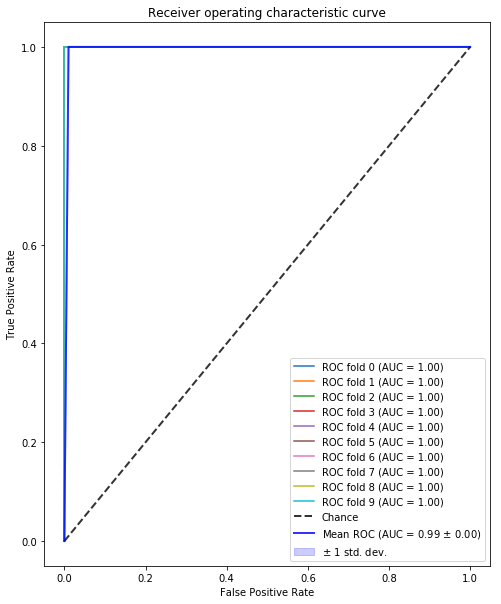

Confusion matrix, without normalization
[[223165      0]
 [     5    340]]


<Figure size 432x288 with 0 Axes>

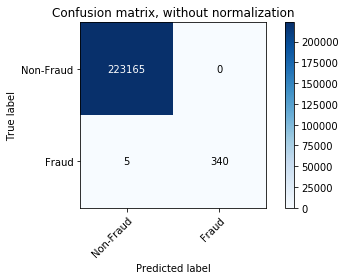

In [47]:
clf = RF(n_estimators=10, criterion='gini', n_jobs=-1)
mean_tpr, std_tpr, mean_auc, std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

#### Quadratic Discriminant Analysis on UNSMOTEd data

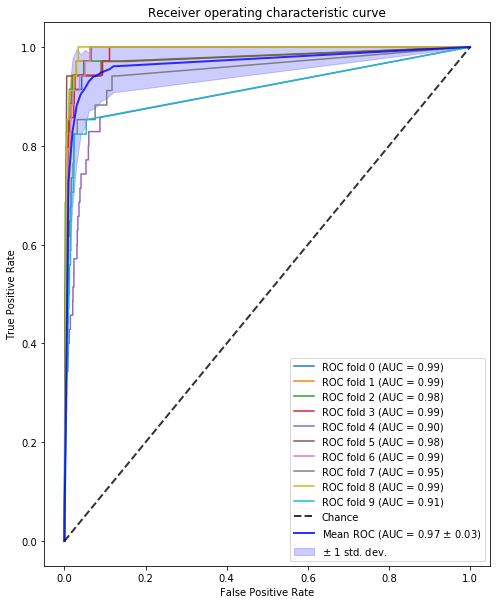

Confusion matrix, without normalization
[[219475   3690]
 [    86    259]]


<Figure size 432x288 with 0 Axes>

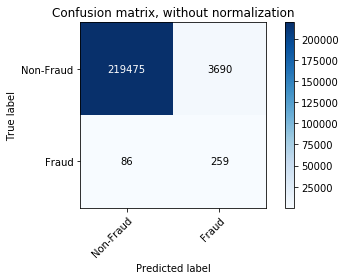

In [60]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

clf = QDA()
mean_tpr, std_tpr, mean_auc, std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

#### SMOTE
- first determine the best over-sampling ratio and the number of nearest neighbours used for the extraction of the random samples, which leads to best performance in terms of mean F1-score
- evaluation is conducted in terms of 10-fold Stratified cross-validation

In [62]:
# Use cross-validation to determine the best overasmpling ratio
# ratios = np.arange(0.1, 1, 0.1)
ratios = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([5, 10, 100])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, y, clf, cv, 
                                                                                False, False, False, False, sm)
#         print("Oversamping ratio: ", r, ", with mean AUC: ", np.round(m_auc, 5), " +- ", np.round(std_auc, 7),
#               " and mean F1: ", np.round(m_F1, 5), " +- ", np.round(std_F1, 7))
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
print("Mean F1:\n", m_F1_cv)

Mean AUC:
 [[0.95076176 0.97558399 0.97528939]
 [0.97702218 0.95254403 0.94302927]
 [0.94727883 0.98200201 0.98399117]
 [0.91554063 0.94851055 0.9490425 ]
 [0.91491852 0.9289865  0.98721025]
 [0.94963465 0.90631396 0.95531567]
 [0.9616632  0.98688299 0.95381076]]
Mean F1:
 [[0.12660507 0.14737893 0.15667368]
 [0.15241506 0.12432969 0.16237643]
 [0.13668406 0.16017317 0.15585815]
 [0.13320664 0.14145536 0.16781656]
 [0.13880583 0.14286591 0.13489232]
 [0.17576225 0.14639307 0.16836144]
 [0.13208106 0.12332259 0.14286189]]


#### Quadratic Discriminant Analysis on SMOTEd data

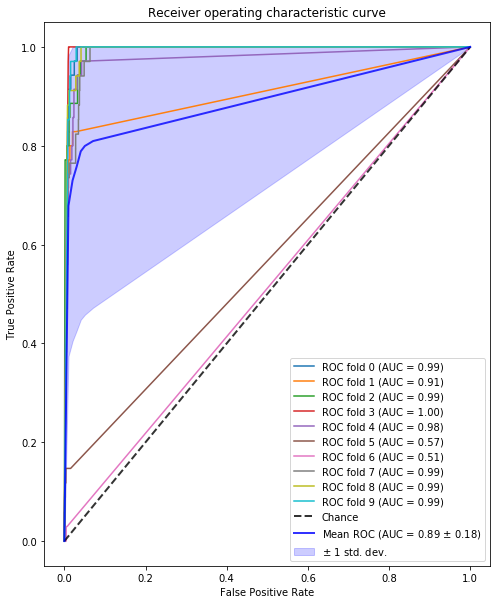

Confusion matrix, without normalization
[[220512   2653]
 [   111    234]]


<Figure size 432x288 with 0 Axes>

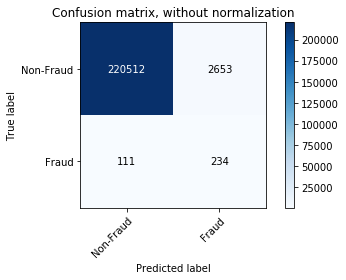

In [64]:
sm = SMOTE(sampling_strategy=0.05, k_neighbors=100)
mean_tpr_sm, std_tpr_sm, mean_auc_sm, std_auc_sm, mean_F1_sm, std_F1_sm, cm_sm = roc_analysis(X, y, clf, cv, True, True, True, False, sm)

#### Combined plot corresponding to SMOTEd and UNSMOTEd case

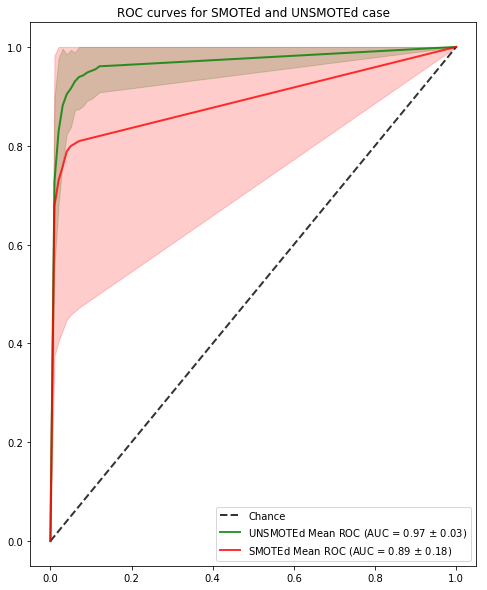

In [66]:
# Combined plot with ROC curves corresponding to the SMOTEd and UNSMOTEd case of the considered classifier
plt.figure(figsize = (8, 10))
plt.title("ROC curves for SMOTEd and UNSMOTEd case")
mean_fpr = np.linspace(0,1,100)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Chance', alpha=.8)

plt.plot(mean_fpr, mean_tpr, color='g',
     label=r'UNSMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1), color ='g', alpha=.2)

plt.plot(mean_fpr, mean_tpr_sm, color='r',
     label=r'SMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_sm, std_auc_sm),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(mean_tpr_sm - std_tpr_sm, 0), np.minimum(mean_tpr_sm + std_tpr_sm, 1), color ='r', alpha=.2)

plt.legend()

#### Adaboost on UNSMOTEd data

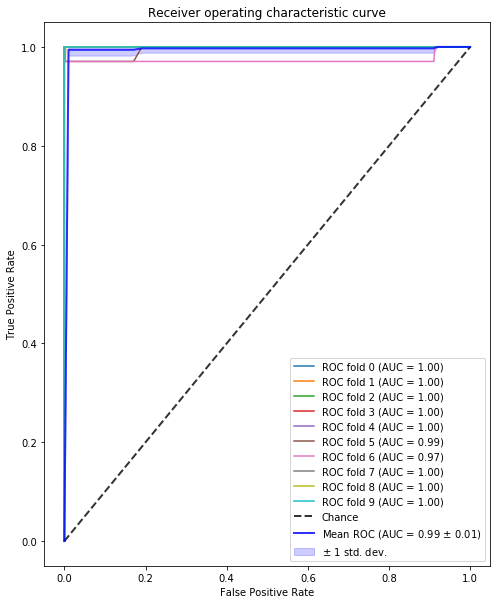

Confusion matrix, without normalization
[[223165      0]
 [     4    341]]


<Figure size 432x288 with 0 Axes>

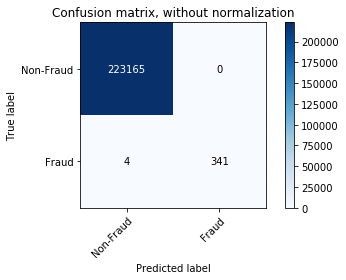

In [68]:
from sklearn.ensemble import AdaBoostClassifier as AdaBoost

clf = AdaBoost(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R')
mean_tpr, std_tpr, mean_auc, std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)